In [118]:
!pip install nolds
!pip install hmmlearn
!pip install yfinance
!pip install statsmodels
!pip install hurst ruptures

In [122]:
import yfinance as yf
import datetime
from numpy import *
from pylab import plot, show

import pandas as pd
import numpy as np

import numpy as np
from pathlib import Path
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
#from google.colab import drive

In [124]:
#Umcomment this method when running from google colab
#def load_data_from_drive(start_date, end_date):
  #drive.mount('/content/drive', force_remount=True)
  #base_path = Path("/content/drive/My Drive/WQU/Capstone/data/parquet_out")
  #dfs = []
  #for d in sorted(base_path.iterdir()):
      #if d.is_dir() and start_date <= d.name <= end_date:
          #dfs.append(pd.read_parquet(d))

  #return pd.concat(dfs, ignore_index=True)

def load_data(start_date, end_date):
  base_path = Path("./data/parquet_out")
  dfs = []
  for d in sorted(base_path.iterdir()):
      if d.is_dir() and start_date <= d.name <= end_date:
          dfs.append(pd.read_parquet(d))

  return pd.concat(dfs, ignore_index=True)




In [126]:
df = load_data("2025-08-01", "2026-01-12")
print(df.head())
print(df.tail())

                        time    symbol bidqty askqty       ltp   atp   ask  \
0  2025-08-01T09:15:00+05:30  NIFTY 50      0      0  24723.55  0.00  0.00   
1  2025-08-01T09:16:00+05:30  NIFTY 50      0      0  24712.80  0.00  0.00   
2  2025-08-01T09:17:00+05:30  NIFTY 50      0      0  24718.15  0.00  0.00   
3  2025-08-01T09:18:00+05:30  NIFTY 50      0      0  24722.50  0.00  0.00   
4  2025-08-01T09:19:00+05:30  NIFTY 50      0      0  24726.00  0.00  0.00   

    bid oi tot_vol tot_buyqty tot_sellqty ltq                  ltt level2  \
0  0.00  0       0          0           0   0  2025-08-01 09:15:00   None   
1  0.00  0       0          0           0   0  2025-08-01 09:16:00   None   
2  0.00  0       0          0           0   0  2025-08-01 09:17:00   None   
3  0.00  0       0          0           0   0  2025-08-01 09:18:00   None   
4  0.00  0       0          0           0   0  2025-08-01 09:19:00   None   

  recv_time bcast_time security_id  
0         0       None      256

**Function to get 1 min data**

In [128]:
def fill_intraday_minutes(day_df):
    day = day_df.index[0].date()
    full_index = pd.date_range(
        start=pd.Timestamp(f"{day} 09:15"),
        end=pd.Timestamp(f"{day} 15:30"),
        freq="1min"
    )
    return day_df.reindex(full_index).ffill()

def get_data_one_min_freq(start_date, end_date):
  df = load_data(start_date=start_date, end_date=end_date)
  df.drop(columns=['time', 'symbol', 'security_id', 'level2', 'bcast_time'], inplace=True)
  df['ltt'] = pd.to_datetime(df['ltt'])
  df = df.sort_values('ltt').set_index('ltt')
  df_1min = (
    df
    .groupby(df.index.date, group_keys=False)
    .apply(fill_intraday_minutes)
  )
  return df_1min



In [132]:
df_1min = get_data_one_min_freq("2025-08-01", "2026-01-12")
print(df_1min.index.to_series().diff().value_counts())
print(df_1min.groupby(df_1min.index.date).size().value_counts())

0 days 00:01:00    41625
0 days 17:45:00       81
2 days 17:45:00       23
1 days 17:45:00        5
3 days 17:45:00        1
Name: count, dtype: int64
376    111
Name: count, dtype: int64


**Function to get 5 mins data**

In [134]:
def fill_intraday_5min(day_df):
    day = day_df.index[0].date()

    # Create fixed 5-min intraday grid
    full_index = pd.date_range(
        start=pd.Timestamp(f"{day} 09:15"),
        end=pd.Timestamp(f"{day} 15:30"),
        freq="5min"
    )

    # Resample to 5-min bars (last price per bar)
    day_5min = (
        day_df
        .resample("5min")
        .last()
    )

    # Reindex to full grid and forward-fill within day
    return day_5min.reindex(full_index).ffill()


def get_data_5min_freq(start_date, end_date):
    df = load_data(start_date=start_date, end_date=end_date)

    df.drop(
        columns=['time', 'symbol', 'security_id', 'level2', 'bcast_time'],
        inplace=True
    )

    df['ltt'] = pd.to_datetime(df['ltt'])
    df = df.sort_values('ltt').set_index('ltt')

    df = df[~df.index.isna()]

    df_5min = (
        df
        .groupby(df.index.date, group_keys=False)
        .apply(fill_intraday_5min)
    )

    return df_5min


In [136]:
df_5min = get_data_5min_freq("2025-08-01", "2026-01-12")
print(df_5min.index.to_series().diff().value_counts())
print(df_5min.groupby(df_5min.index.date).size().value_counts())

0 days 00:05:00    8325
0 days 17:45:00      81
2 days 17:45:00      23
1 days 17:45:00       5
3 days 17:45:00       1
Name: count, dtype: int64
76    111
Name: count, dtype: int64


In [138]:
df_5min.groupby(df_5min.index.date).size().head()

2025-08-01    76
2025-08-04    76
2025-08-05    76
2025-08-06    76
2025-08-07    76
dtype: int64

**Function to get 15 mins data**

In [141]:
def fill_intraday_15min(day_df):
    day = day_df.index[0].date()

    # Create fixed 15-min intraday grid
    full_index = pd.date_range(
        start=pd.Timestamp(f"{day} 09:15"),
        end=pd.Timestamp(f"{day} 15:30"),
        freq="15min"
    )

    # Resample to 5-min bars (last price per bar)
    day_15min = (
        day_df
        .resample("15min")
        .last()
    )

    # Reindex to full grid and forward-fill within day
    return day_15min.reindex(full_index).ffill()


def get_data_15min_freq(start_date, end_date):
    df = load_data(start_date=start_date, end_date=end_date)

    df.drop(
        columns=['time', 'symbol', 'security_id', 'level2', 'bcast_time'],
        inplace=True
    )

    df['ltt'] = pd.to_datetime(df['ltt'])
    df = df.sort_values('ltt').set_index('ltt')

    df = df[~df.index.isna()]

    df_15min = (
        df
        .groupby(df.index.date, group_keys=False)
        .apply(fill_intraday_15min)
    )

    return df_15min


In [143]:
df_15min = get_data_15min_freq("2025-08-01", "2026-01-12")
print(df_15min.index.to_series().diff().value_counts())
print(df_15min.groupby(df_15min.index.date).size().value_counts())

0 days 00:15:00    2775
0 days 17:45:00      81
2 days 17:45:00      23
1 days 17:45:00       5
3 days 17:45:00       1
Name: count, dtype: int64
26    111
Name: count, dtype: int64


In [145]:
df_15min.tail()

,bidqty,askqty,ltp,atp,ask,bid,oi,tot_vol,tot_buyqty,tot_sellqty,ltq,recv_time
2026-01-12 14:30:00,0,0,25760.80,0.00,0.00,0.00,0,0,0,0,0,0
2026-01-12 14:45:00,0,0,25810.45,0.00,0.00,0.00,0,0,0,0,0,0
2026-01-12 15:00:00,0,0,25778.50,0.00,0.00,0.00,0,0,0,0,0,0
2026-01-12 15:15:00,0,0,25806.10,0.00,0.00,0.00,0,0,0,0,0,0
2026-01-12 15:30:00,0,0,25806.10,0.00,0.00,0.00,0,0,0,0,0,0


In [147]:
df_15min.groupby(df_15min.index.date).size().head()

2025-08-01    26
2025-08-04    26
2025-08-05    26
2025-08-06    26
2025-08-07    26
dtype: int64

Function to get 60 mins data

In [150]:
NUMERIC_COLS = [
    "tot_vol", "ask", "bid", "oi", "askqty", "bidqty",
    "tot_buyqty", "tot_sellqty", "ltq", "atp"
]

for col in NUMERIC_COLS:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")



PRICE_COL = "ltp"
VOLUME_COL = "tot_vol"

LAST_COLS = [
    "ask", "bid", "oi", "askqty", "bidqty",
    "tot_buyqty", "tot_sellqty", "ltq", "atp", "recv_time"
]



def build_agg_dict(df):
  agg = {
      PRICE_COL: ["first", "max", "min", "last"],
      VOLUME_COL: "sum"
  }

  for col in LAST_COLS:
    if col in df.columns:
      agg[col] = "last"
  return agg


def get_data_60min_freq(start_date, end_date):
    df = load_data(start_date=start_date, end_date=end_date)

    df.drop(
        columns=['time', 'symbol', 'security_id', 'level2', 'bcast_time'],
        inplace=True
    )


    NUMERIC_COLS = [
        "tot_vol", "ask", "bid", "oi",
        "askqty", "bidqty", "tot_buyqty",
        "tot_sellqty", "ltq", "atp"
    ]

    for col in NUMERIC_COLS:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    df['ltt'] = pd.to_datetime(df['ltt'], errors="coerce")
    df = df.sort_values('ltt').set_index('ltt')
    df = df[~df.index.isna()]

    df_60min = (
        df
        .groupby(df.index.date, group_keys=False)
        .apply(fill_intraday_60min)
    )

    return df_60min


def fill_intraday_60min(day_df):
    day = day_df.index[0].date()

    full_index = pd.date_range(
        start=pd.Timestamp(f"{day} 09:15"),
        end=pd.Timestamp(f"{day} 15:15"),
        freq="60min"
    )

    agg_dict = build_agg_dict(day_df)

    day_60min = (
    day_df
    .resample(
        "60min",
        origin=pd.Timestamp(f"{day} 09:15"),
        label="right",
        closed="right"
    )
    .agg(agg_dict)
    )

    day_60min.columns = [
        f"{c[0]}_{c[1]}" if isinstance(c, tuple) else c
        for c in day_60min.columns
    ]

    return day_60min.reindex(full_index).ffill()



In [152]:
df_60min = get_data_60min_freq("2025-08-01", "2026-01-12")
print(df_60min.index.to_series().diff().value_counts())
print(df_60min.groupby(df_60min.index.date).size().value_counts())

0 days 01:00:00    666
0 days 18:00:00     81
2 days 18:00:00     23
1 days 18:00:00      5
3 days 18:00:00      1
Name: count, dtype: int64
7    111
Name: count, dtype: int64


In [154]:
df_60min.index.name = 'time'
df_60min.tail()

,ltp_first,ltp_max,ltp_min,ltp_last,tot_vol_sum,ask_last,bid_last,oi_last,askqty_last,bidqty_last,tot_buyqty_last,tot_sellqty_last,ltq_last,atp_last,recv_time_last
time,,,,,,,,,,,,,,,
2026-01-12 11:15:00,25550.40,25595.30,25528.80,25528.80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2026-01-12 12:15:00,25526.15,25578.30,25475.00,25577.45,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2026-01-12 13:15:00,25583.40,25732.20,25583.40,25725.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2026-01-12 14:15:00,25726.60,25751.55,25689.05,25729.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2026-01-12 15:15:00,25734.05,25812.45,25705.70,25784.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [61]:
# Generate Returns 


In [156]:
# ===============================================================
#  MARKET-DYNAMICS  –  Diagnostics  (quiet & threshold-tunable)
# ===============================================================
import numpy as np, pandas as pd, warnings
from statsmodels.tsa.stattools    import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.sm_exceptions import InterpolationWarning
from scipy.stats  import kurtosis
from hurst        import compute_Hc
import ruptures as rpt

# ── silence spammy warnings ─────────────────────────────────────
warnings.filterwarnings("ignore", category=InterpolationWarning)
warnings.filterwarnings("ignore", category=UserWarning,
                        module="statsmodels.tsa.stattools")
np.seterr(divide="ignore", invalid="ignore")

# ── load price series (ltp) ────────────────────────────────────
df_1m = get_data_one_min_freq("2025-08-01", "2026-01-12")
if "time" in df_1m.columns:
    df_1m = df_1m.set_index("time")
df_1m.index = (df_1m.index.tz_localize("Asia/Kolkata")
               if df_1m.index.tz is None
               else df_1m.index.tz_convert("Asia/Kolkata"))
close   = pd.to_numeric(df_1m["ltp"], errors="coerce").dropna()
returns = close.pct_change().dropna()

# ── helpers ────────────────────────────────────────────────────
WINDOW = 250
roll_p = lambda s, fn: s.rolling(WINDOW).apply(lambda x: fn(x)[1], raw=False)

adf_p  = roll_p(returns, lambda x: adfuller(x, maxlag=12))
kpss_p = roll_p(returns, lambda x: kpss(x, nlags="auto"))
lb_df  = acorr_ljungbox(returns**2, lags=[10, 20], return_df=True)

kurt_ex  = returns.rolling(WINDOW).apply(
    lambda x: kurtosis(x, fisher=True, bias=False), raw=False
)
tail = returns.abs().sort_values(ascending=False)
k    = max(int(0.05 * len(tail)), 1)
hill_alpha = k / np.log(tail.iloc[:k] / tail.iloc[k-1]).sum()

rv  = returns.rolling(30).std().dropna()
H, *_ = compute_Hc(rv, kind="change", simplified=True)
n_breaks = len(rpt.Binseg("l2").fit(returns.values).predict(pen=10)) - 1

# ── summary ────────────────────────────────────────────────────
summary = pd.Series({
    "ADF pass-fraction"     : (adf_p  < 0.05).mean(),
    "KPSS pass-fraction"    : (kpss_p > 0.05).mean(),
    "LB p-lag10"            : lb_df.loc[10, "lb_pvalue"],
    "LB p-lag20"            : lb_df.loc[20, "lb_pvalue"],
    "Kurtosis>2 fraction"   : (kurt_ex > 2).mean(),
    "Hill alpha"            : hill_alpha,
    "Hurst (rv)"            : H,
    "Breakpoints"           : n_breaks
})
display(summary)

# ── gate rules (tweakable) ─────────────────────────────────────
LB_THRESHOLD   = 0.10   # raise from 0.05 if clustering is weak
HURST_MIN      = 0.55

gate_pass = (
    summary["ADF pass-fraction"]   >= 0.70 and
    summary["KPSS pass-fraction"]  >= 0.70 and
    summary["LB p-lag10"] < LB_THRESHOLD and
    summary["LB p-lag20"] < LB_THRESHOLD and
    (summary["Kurtosis>2 fraction"] > 0.30 or summary["Hill alpha"] < 4) and
    summary["Hurst (rv)"] > HURST_MIN
)

print("\nMARKET-DYNAMICS  GATE:", "PASS ✅" if gate_pass else "FAIL ❌")


ADF pass-fraction      0.993730
KPSS pass-fraction     0.957120
LB p-lag10             0.960617
LB p-lag20             0.999780
Kurtosis>2 fraction    0.721982
Hill alpha             2.992847
Hurst (rv)             0.682564
Breakpoints            0.000000
dtype: float64


MARKET-DYNAMICS  GATE: FAIL ❌


In [ ]:
# PATH A 

In [162]:
# ────────────────────────────────────────────────────────
#  PATH A  –  Lag Sweep on 1-min Returns
#      Goal: find the lags where volatility clustering (ARCH-type)
#            is statistically significant.
# ────────────────────────────────────────────────────────
import pandas as pd
from statsmodels.stats.diagnostic import acorr_ljungbox

# 1-min absolute-squared returns
lags  = [1, 2, 3, 5, 10, 15, 20, 30, 60]       # minutes
lb_df = acorr_ljungbox(returns**2, lags=lags, return_df=True)

# Assemble p-values in a tidy DataFrame
lag_sweep = pd.DataFrame({
    "Lag (min)" : lags,
    "LB p-value": lb_df["lb_pvalue"].values
})
display(lag_sweep)

# Highlight the first lag that shows clustering
first_sig = lag_sweep.loc[lag_sweep["LB p-value"] < 0.05]
if not first_sig.empty:
    print(f"\n✅ Volatility clustering detected at lag {first_sig.iloc[0,0]}-min "
          f"(p = {first_sig.iloc[0,1]:.4f})")
else:
    print("\nℹ️  No Ljung-Box p-value below 0.05 for lags 1–60 min")


,Lag (min),LB p-value
0,1,0.235923
1,2,0.383560
2,3,0.511716
3,5,0.762802
4,10,0.960617
5,15,0.995739
6,20,0.999780
7,30,1.000000
8,60,1.000000



ℹ️  No Ljung-Box p-value below 0.05 for lags 1–60 min


In [ ]:
# PATH B 

In [164]:
# ─────────────────────────────────────────────────────────────
#  PATH B – Horizon Sweep (5-min & 15-min returns)
#      Goal: see whether volatility clustering appears after
#            smoothing 1-min noise.
# ─────────────────────────────────────────────────────────────
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd

horizons   = {"5min": [1, 2, 4, 8],   # lags in multiples of the horizon
              "15min": [1, 2, 3, 4]}  # (e.g., 4 × 15 min = 1 hour)

results = []

for tf, lags in horizons.items():
    # resample close prices to tf bars and compute returns
    r_tf = close.resample(tf).last().pct_change().dropna()
    
    lb_df = acorr_ljungbox(r_tf**2, lags=lags, return_df=True, model_df=0)
    
    res = pd.DataFrame({
        "Horizon"   : tf,
        "Lag(mult)" : lags,
        "LB p-val"  : lb_df["lb_pvalue"].values
    })
    results.append(res)

lb_sweep_tf = pd.concat(results, ignore_index=True)
display(lb_sweep_tf)

# Flag first significant clustering per horizon
for tf in lb_sweep_tf["Horizon"].unique():
    sub = lb_sweep_tf[lb_sweep_tf["Horizon"] == tf]
    sig = sub[sub["LB p-val"] < 0.05]
    if not sig.empty:
        lag = sig.iloc[0]["Lag(mult)"]
        p   = sig.iloc[0]["LB p-val"]
        print(f"✅ {tf}: clustering at lag {lag}×{tf} (p = {p:.4f})")
    else:
        print(f"ℹ️  {tf}: no significant clustering (p < 0.05) up to max lag tested")


,Horizon,Lag(mult),LB p-val
0,5min,1,2.824385e-10
1,5min,2,2.767913e-13
2,5min,4,1.425436e-19
3,5min,8,1.329829e-24
4,15min,1,1.953027e-05
5,15min,2,4.269477e-06
6,15min,3,1.208005e-07
7,15min,4,1.343749e-07


✅ 5min: clustering at lag 1×5min (p = 0.0000)
✅ 15min: clustering at lag 1×15min (p = 0.0000)


In [ ]:
# Market-Dynamics Gate” cell—updated for 5-minute clustering (Path B)

In [166]:
# =============================================================
# MARKET-DYNAMICS  –  Diagnostics Gate  (5-min clustering version)
# =============================================================
import numpy as np, pandas as pd, warnings
from statsmodels.tsa.stattools    import adfuller, kpss
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.sm_exceptions import InterpolationWarning
from scipy.stats  import kurtosis
from hurst        import compute_Hc
import ruptures as rpt

# ── Silence warning spam ──────────────────────────────────────
warnings.filterwarnings("ignore", category=InterpolationWarning)
warnings.filterwarnings("ignore", category=UserWarning,
                        module="statsmodels.tsa.stattools")
np.seterr(divide="ignore", invalid="ignore")

# ── 1) Load 1-minute price series (ltp) ───────────────────────
df_1m = get_data_one_min_freq("2025-08-01", "2026-01-12")
if "time" in df_1m.columns:
    df_1m = df_1m.set_index("time")
df_1m.index = (df_1m.index.tz_localize("Asia/Kolkata")
               if df_1m.index.tz is None
               else df_1m.index.tz_convert("Asia/Kolkata"))
close   = pd.to_numeric(df_1m["ltp"], errors="coerce").dropna().astype(float)
ret_1m  = close.pct_change().dropna()

# ── 2) 5-minute returns for clustering check ─────────────────
ret_5m  = close.resample("5min").last().pct_change().dropna()
lb5_p   = acorr_ljungbox(ret_5m**2, lags=[1], return_df=True)["lb_pvalue"].iloc[0]

# ── 3) Stationarity on 1-min returns ─────────────────────────
WINDOW = 250
adf_p  = ret_1m.rolling(WINDOW).apply(lambda x: adfuller(x, maxlag=12)[1], raw=False)
kpss_p = ret_1m.rolling(WINDOW).apply(lambda x: kpss(x, nlags="auto")[1], raw=False)

# ── 4) Heavy tails (1-min) ───────────────────────────────────
kurt_ex   = ret_1m.rolling(WINDOW).apply(
    lambda x: kurtosis(x, fisher=True, bias=False), raw=False
)
tail       = ret_1m.abs().sort_values(ascending=False)
k          = max(int(0.05 * len(tail)), 1)
hill_alpha = k / np.log(tail.iloc[:k] / tail.iloc[k-1]).sum()

# ── 5) Vol-persistence (Hurst of 5-min RV) ───────────────────
rv_5m = ret_5m.rolling(12).std().dropna()   # 1-hour window
H, *_ = compute_Hc(rv_5m, kind="change", simplified=True)

# ── 6) Structural breaks (1-min) ─────────────────────────────
n_breaks = len(rpt.Binseg("l2").fit(ret_1m.values).predict(pen=10)) - 1

# ── 7) Summary table ─────────────────────────────────────────
summary = pd.Series({
    "ADF pass-fraction"     : (adf_p  < 0.05).mean(),
    "KPSS pass-fraction"    : (kpss_p > 0.05).mean(),
    "LB p-val 5-min lag-1"  : lb5_p,
    "Kurtosis>2 fraction"   : (kurt_ex > 2).mean(),
    "Hill alpha"            : hill_alpha,
    "Hurst (rv-5m)"         : H,
    "Breakpoints"           : n_breaks
})
display(summary)

# ── 8) Gate criteria ─────────────────────────────────────────
gate_pass = (
    summary["ADF pass-fraction"]  >= 0.70    and
    summary["KPSS pass-fraction"] >= 0.70    and
    summary["LB p-val 5-min lag-1"] < 0.05   and  # new clustering rule
    (summary["Kurtosis>2 fraction"] > 0.30 or summary["Hill alpha"] < 4) and
    summary["Hurst (rv-5m)"] > 0.55
)

print("\nMARKET-DYNAMICS  GATE:", "PASS ✅" if gate_pass else "FAIL ❌")


ADF pass-fraction       9.937297e-01
KPSS pass-fraction      9.571205e-01
LB p-val 5-min lag-1    2.824385e-10
Kurtosis>2 fraction     7.219824e-01
Hill alpha              2.992847e+00
Hurst (rv-5m)           6.987494e-01
Breakpoints             0.000000e+00
dtype: float64


MARKET-DYNAMICS  GATE: PASS ✅


In [ ]:
## Fractal-Persistence Module — rolling Hurst on price & volatility


In [168]:
# ======================================================
#  CELL ①  –  PREP   (works even with sparse tick data)
# ======================================================
import pandas as pd, numpy as np

# ---- 1. 1-minute close series ----------------------------------------
close_1m = (
    pd.to_numeric(df_1m["ltp"], errors="coerce")   # df_1m already in memory
      .dropna()
      .astype(float)
      .sort_index()
)

assert close_1m.index.is_monotonic_increasing, "1-min index not monotonic"
assert close_1m.index.tz is not None,          "timestamps must be tz-aware"

# ---- 2. Restrict to trading session (09:15–15:30 IST) ----------------
mkt_1m = close_1m.between_time("09:15", "15:30")

# ---- 3. Helper: forward-fill gaps only *within* each day -------------
def resample_ffill(session_series: pd.Series, freq="5min") -> pd.Series:
    parts = []
    for _, sub in session_series.groupby(session_series.index.date):
        parts.append(
            sub.resample(freq).last().ffill()     # last price → ffill intraday
        )
    return pd.concat(parts)

# ---- 4. 5-minute close  ----------------------------------------------
close_5m = resample_ffill(mkt_1m, "5min")

# ---- 5. 5-minute realised volatility ---------------------------------
# (std of 5 successive 1-min returns, aligned & ffilled like price)
rv_raw  = mkt_1m.pct_change().rolling(5).std()
rv_5m   = resample_ffill(rv_raw.dropna(), "5min").reindex(close_5m.index)

# ---- 6. Sanity checks -------------------------------------------------
gap_ratio = close_5m.isna().mean()
print(f"Remaining NaNs in 5-min close after ffill: {gap_ratio:.2%}")
assert gap_ratio < 0.01, "Still too many gaps after forward-fill (<1 % required)"

print("\nSeries ready:"
      f"\n  close_1m  → {len(close_1m):,} rows"
      f"\n  close_5m  → {len(close_5m):,} rows"
      f"\n  rv_5m     → {len(rv_5m):,} rows")


Remaining NaNs in 5-min close after ffill: 0.00%

Series ready:
  close_1m  → 41,466 rows
  close_5m  → 8,382 rows
  rv_5m     → 8,382 rows


In [170]:
# ===================================================================
#  CELL ②  –  Fractal-Persistence diagnostics  (NaN-safe, fast)
# ===================================================================
import numpy as np, pandas as pd, warnings, os
from hurst import compute_Hc
from tqdm import tqdm

warnings.filterwarnings("ignore")
np.seterr(divide="ignore", invalid="ignore")

# ───────── helper: DFA Hurst, tolerant to zeros & NaNs ──────────────
def hurst_dfa_safe(arr: np.ndarray) -> float:
    if np.isnan(arr).any() or np.allclose(arr.max() - arr.min(), 0):
        return np.nan
    h, *_ = compute_Hc(arr + 1e-8, kind="change", simplified=True)
    return float(h)

def rolling_hurst(series: pd.Series, window: int, tag: str,
                  step: int = 5) -> pd.Series:
    """
    Compute H every <step> windows; NaN if slice has NaNs or flat.
    Then forward-fill to full index.
    """
    idx_out, vals = [], []
    arr = series.values
    for i in tqdm(range(window, len(arr) + 1, step), desc=f"H({tag})"):
        vals.append(hurst_dfa_safe(arr[i-window:i]))
        idx_out.append(series.index[i-1])
    coarse = pd.Series(vals, index=idx_out)
    return coarse.reindex(series.index, method="ffill")

# ───────── parameters ───────────────────────────────────────────────
WIN_5M, STEP, BOOT_N = 125, 5, 50   # 2-day window, 25-min stride, 50 bootstraps

# ───────── rolling H on 5-min price & RV ────────────────────────────
H_5m = rolling_hurst(close_5m, WIN_5M, "price-5m", STEP).rename("hurst_price_5m")
H_rv = rolling_hurst(rv_5m,    WIN_5M, "rv-5m",    STEP).rename("hurst_rv_5m")

print("\nNaN ratio after rolling-H:")
print("  hurst_price_5m:", H_5m.isna().mean())
print("  hurst_rv_5m   :", H_rv.isna().mean())

# ───────── light bootstrap 90 % CI on price-H ───────────────────────
ci_lo, ci_hi = [], []
for ts in tqdm(H_5m.index[::STEP], desc="Boot CI"):
    win = close_5m.loc[ts - pd.Timedelta(minutes=5*(WIN_5M-1)): ts]
    boots = [hurst_dfa_safe(np.random.choice(win.values, size=WIN_5M, replace=True))
             for _ in range(BOOT_N)]
    lo, hi = np.nanpercentile(boots, [5, 95])
    ci_lo.append(lo); ci_hi.append(hi)

ci_lo = pd.Series(ci_lo, index=H_5m.index[::STEP]).reindex(H_5m.index, method="ffill")
ci_hi = pd.Series(ci_hi, index=H_5m.index[::STEP]).reindex(H_5m.index, method="ffill")
ci_width = (ci_hi - ci_lo).mean()

# ───────── regime label & feature frame ─────────────────────────────
label  = lambda h: "AP" if h < 0.45 else ("P" if h > 0.55 else "Noise")
regime = H_5m.apply(label).rename("hurst_regime")

feat = (
    pd.concat([H_5m, H_rv, regime], axis=1)
      .dropna()                              # drop rows with any NaNs
      .reset_index()
      .rename(columns={"index": "timestamp"})
)

print("\nFinal feature frame shape:", feat.shape)
print("NaN check per column:\n", feat.isna().mean())

# ───────── export clean CSV ─────────────────────────────────────────
os.makedirs("features", exist_ok=True)
feat.to_csv("features/regime_features.csv", index=False, float_format="%.6f")
print("\nSaved → features/regime_features.csv")

# ───────── gate decision ────────────────────────────────────────────
gate_pass = (
    ci_width < 0.10
    and (feat["hurst_regime"] == "AP").mean() > 0.10
    and (feat["hurst_regime"] == "P").mean()  > 0.10
)

print(f"Average 90 % CI width on H(5-min price): {ci_width:.3f}")
print("FRACTAL-PERSISTENCE GATE:", "PASS ✅" if gate_pass else "FAIL ❌")


H(rv-5m): 100%|██████████| 1652/1652 [00:00<00:00, 2462.55it/s]



NaN ratio after rolling-H:
  hurst_price_5m: 0.014793605344786447
  hurst_rv_5m   : 0.015390121689334287


Boot CI: 100%|██████████| 1677/1677 [00:33<00:00, 49.62it/s]



Final feature frame shape: (8253, 4)
NaN check per column:
 timestamp         0.0
hurst_price_5m    0.0
hurst_rv_5m       0.0
hurst_regime      0.0
dtype: float64

Saved → features/regime_features.csv
Average 90 % CI width on H(5-min price): 0.059
FRACTAL-PERSISTENCE GATE: PASS ✅


In [186]:
# =========================================================
#  MASTER 5-MIN FEATURE SET  –  FINAL BUILD  (CSV, tz-safe)
# =========================================================
import pandas as pd, numpy as np, os

tz = "Asia/Kolkata"

# ---------- Hurst / regime table --------------------------------------
reg = (pd.read_csv("features/regime_features.csv", parse_dates=["timestamp"])
         .set_index("timestamp")
         .sort_index())
reg.index = reg.index.tz_convert(tz) if reg.index.tz else reg.index.tz_localize(tz)

# ---------- 1-min prices ----------------------------------------------
df_1m = get_data_one_min_freq("2025-08-01", "2026-01-12")
close_1m = (pd.to_numeric(df_1m["ltp"], errors="coerce")
              .dropna().astype(float).sort_index())
close_1m.index = (close_1m.index.tz_convert(tz) if close_1m.index.tz
                  else close_1m.index.tz_localize(tz))
close_1m = close_1m.between_time("09:15", "15:30")

# ---------- in-session 5-min bars -------------------------------------
def intra_ffill(s):            # resample & ffill **inside** the day
    return s.resample("5min").last().ffill()

close_5m = (close_1m.groupby(close_1m.index.date)
                     .apply(intra_ffill)
                     .reset_index(level=0, drop=True))

# realised vol: std over latest 5×1-min returns, then onto same grid
rv_5m = (close_1m.pct_change().rolling(5, min_periods=5).std()
           .groupby(close_1m.index.date)
           .apply(intra_ffill)
           .reset_index(level=0, drop=True)
           .reindex(close_5m.index))

# lag-1 AC over a **30-bar window** (≈ 2½ hours) — gives stable numbers
ret_5m = close_5m.pct_change()
ac1_5m = (ret_5m.rolling(30, min_periods=30)
                   .apply(lambda x: x.autocorr(lag=1)))

# small gaps (first day, holiday half-day) → forward-fill a single step
aux = pd.DataFrame({
        "log_rv": np.log(rv_5m).ffill(limit=1),
        "ac1_5m": ac1_5m.ffill(limit=1)
    }, index=close_5m.index)

# ---------- merge ------------------------------------------------------
feat = reg.join(aux, how="inner").dropna()

print("rows after join:", len(feat))           # should be ~8k

# reorder & save
feat = feat[["log_rv", "ac1_5m",
             "hurst_price_5m", "hurst_rv_5m", "hurst_regime"]]

os.makedirs("features", exist_ok=True)
feat.reset_index().to_csv("features/master_5m.csv",
                          index=False, float_format="%.6f")
print("✅  Saved  features/master_5m.csv")


rows after join: 8253
✅  Saved  features/master_5m.csv


In [193]:
# ─────────────────────────────────────────────────────────────
#  CELL A – load master_5m.csv  ➜  clean  ➜  observation matrix
# ─────────────────────────────────────────────────────────────
import pandas as pd, numpy as np
from sklearn.preprocessing import StandardScaler

MASTER = "features/master_5m.csv"

# 1) Load & index
raw = pd.read_csv(MASTER)
if "timestamp" not in raw.columns:
    raw = raw.rename(columns={raw.columns[0]: "timestamp"})
feat = raw.set_index(pd.to_datetime(raw["timestamp"])).drop(columns="timestamp")

# 2) Replace infinities / huge values  -------------------------------------------------
feat["log_rv"].replace([np.inf, -np.inf], np.nan, inplace=True)
feat["ac1_5m"].replace([np.inf, -np.inf], np.nan, inplace=True)

# optional: clip extreme outliers in ac1_5m to [-1,1]
feat["ac1_5m"] = feat["ac1_5m"].clip(-1, 1)

# 3) Drop remaining NaNs on the two modelling columns
feat = feat.dropna(subset=["log_rv", "ac1_5m"])

print("✓ cleaned  |  rows:", len(feat))

# 4) Observation matrix
X_raw  = feat[["log_rv", "ac1_5m"]].values
scaler = StandardScaler().fit(X_raw)
X      = scaler.transform(X_raw)

# 5) supervised seed
seed_states = np.where(feat["hurst_regime"] == "AP", 0,
               np.where(feat["hurst_regime"] == "P", 2, 1))

print("Observation matrix shape:", X.shape)


✓ cleaned  |  rows: 8243
Observation matrix shape: (8243, 2)


In [201]:
# =========================================================
#  CELL B – Robust grid-search  (states 2-4  ×  diag/full)
# =========================================================
from hmmlearn.hmm import GaussianHMM
import pandas as pd, numpy as np, warnings, contextlib, sys
warnings.filterwarnings("ignore")

def fit_try(Xin, seed, n, cov):
    """fit HMM; return (model, AIC, BIC) or None on numerical failure"""
    try:
        mdl = GaussianHMM(n_components=n,
                          covariance_type=cov,
                          n_iter=250,
                          random_state=42,
                          init_params="st")      # keep our mean/covar seeds

        mdl.means_  = np.array([Xin[seed==i].mean(0) for i in range(n)])
        if cov == "full":
            mdl.covars_ = np.array([np.cov(Xin[seed==i].T) for i in range(n)])
        else:                               # diag
            mdl.covars_ = np.array([Xin[seed==i].var(axis=0) for i in range(n)])

        with np.errstate(all="ignore"):     # silence underflow warnings
            mdl.fit(Xin)
        return mdl, mdl.aic(Xin), mdl.bic(Xin)
    except Exception:
        return None

rows = []
for n in [2, 3, 4]:
    for cov in ["diag", "full"]:
        out = fit_try(X, seed_states, n, cov)
        if out is None:
            rows.append([n, cov, "fail", "fail"])
        else:
            mdl, aic, bic = out
            rows.append([n, cov, aic, bic])

grid_df = pd.DataFrame(rows, columns=["states", "cov", "AIC", "BIC"])
display(grid_df)

# choose best surviving combo
valid = grid_df[grid_df["BIC"] != "fail"]
best_n, best_cov = valid.sort_values("BIC").iloc[0][["states", "cov"]]
print(f"\n🠖 selected by BIC  →  n_states = {best_n}   |   cov_type = '{best_cov}'")


,states,cov,AIC,BIC
0,2,diag,40279.473643,40356.661959
1,2,full,40275.14825,40366.370805
2,3,diag,40158.654641,40298.997033
3,3,full,36820.535555,36981.929307
4,4,diag,fail,fail
5,4,full,fail,fail



🠖 selected by BIC  →  n_states = 3   |   cov_type = 'full'


Fold 2026:  train ≤ 2025,  test 2026

✅  Saved decoded states →  features/hmm_states.parquet

Bars per state:
state
2    384
1    113
0    111
Name: count, dtype: int64 

Cluster centres (raw units):
     log_rv    ac1_5m
0 -8.690333  0.102824
1 -8.697890  0.102405
2 -8.726602 -0.173054 



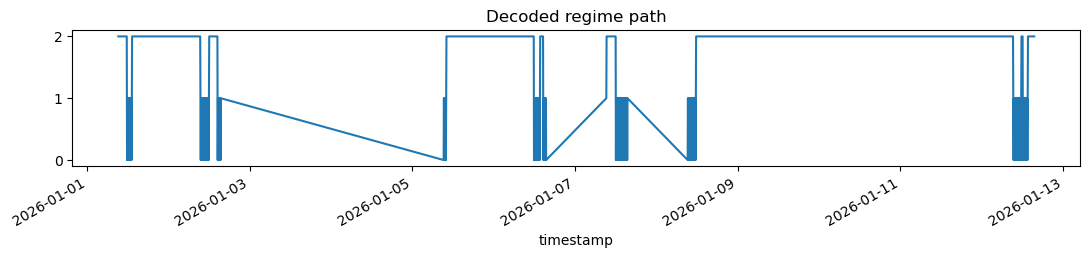

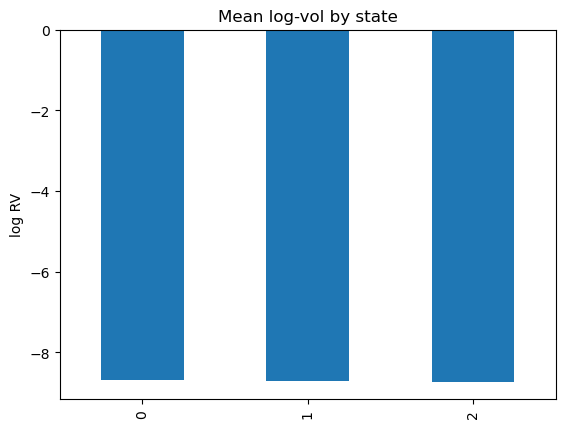

In [205]:
# =========================================================
#  CELL C – Walk-forward TRAIN ➜ DECODE ➜ SAVE  +  Diagnostics
#  ---------------------------------------------------------
#  • Requires:  `feat`, `scaler`, `seed_states`  (from Cell A)
#               `best_n`, `best_cov`            (from Cell B)
#  • Saves:
#        models/hmm_<year>.pkl
#        features/hmm_states.parquet
#  • Prints per-state sample sizes and raw-unit cluster centres
# =========================================================
from hmmlearn.hmm import GaussianHMM
import joblib, os, numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
warnings.filterwarnings("ignore")

MODEL_DIR  = "models"
STATE_FILE = "features/hmm_states.parquet"
os.makedirs(MODEL_DIR, exist_ok=True)

# ---------- helper: calendar-year folds -------------------
def yearly_folds(df):
    for yr, test in df.groupby(df.index.year):
        train = df[df.index.year < yr]
        if len(train) and len(test):
            yield yr, train, test

decoded_parts = []

for yr, ins, out in yearly_folds(feat):
    print(f"Fold {yr}:  train ≤ {yr-1},  test {yr}")

    # ---- supervised initial means / covs -----------------
    seed = np.where(ins["hurst_regime"] == "AP", 0,
            np.where(ins["hurst_regime"] == "P", 2, 1))
    Xin  = scaler.transform(ins[["log_rv", "ac1_5m"]])

    hmm = GaussianHMM(n_components=int(best_n),
                      covariance_type=str(best_cov),
                      n_iter=250,
                      random_state=42,
                      init_params="st")            # keep seeded m & c

    hmm.means_  = np.array([Xin[seed == i].mean(0) for i in range(best_n)])
    if best_cov == "full":
        hmm.covars_ = np.array([np.cov(Xin[seed == i].T) for i in range(best_n)])
    else:  # diag
        hmm.covars_ = np.array([Xin[seed == i].var(axis=0) for i in range(best_n)])

    hmm.fit(Xin)
    joblib.dump(hmm, f"{MODEL_DIR}/hmm_{yr}.pkl")

    # ---- decode out-sample --------------------------------
    Xout   = scaler.transform(out[["log_rv", "ac1_5m"]])
    states = hmm.predict(Xout)
    probs  = hmm.predict_proba(Xout)

    tmp = out.copy()[["log_rv", "ac1_5m"]]
    tmp["state"] = states
    tmp[[f"p{i}" for i in range(best_n)]] = probs
    decoded_parts.append(tmp)

# ---------- concatenate & save -----------------------------
decoded = pd.concat(decoded_parts)
decoded.to_parquet(STATE_FILE)
print(f"\n✅  Saved decoded states →  {STATE_FILE}")

# ---------- diagnostics ------------------------------------
print("\nBars per state:")
print(decoded["state"].value_counts(), "\n")

# cluster centres from the most-recent model (last fold)
last_year = decoded.index.year.max()
hmm_last  = joblib.load(f"{MODEL_DIR}/hmm_{last_year}.pkl")
centres_raw = pd.DataFrame(
    scaler.inverse_transform(hmm_last.means_),
    columns=["log_rv", "ac1_5m"]
)
print("Cluster centres (raw units):")
print(centres_raw, "\n")

# quick visual check
decoded["state"].plot(figsize=(13,2), title="Decoded regime path"); plt.show()
centres_raw["log_rv"].plot(kind="bar", title="Mean log-vol by state"); plt.ylabel("log RV"); plt.show()


In [209]:
# =========================================================
#  4.5  Robustness checks  –  underflow-safe version
#  ---------------------------------------------------------
#  • five random seeds  +  one jack-knife cut
#  • writes  features/hmm_robustness.csv
# =========================================================
import pandas as pd, numpy as np, joblib, os, warnings
from hmmlearn.hmm import GaussianHMM
warnings.filterwarnings("ignore")
os.makedirs("features", exist_ok=True)

def safe_fit(Xin, seed_vec, n, cov, rnd, jitter=0.0):
    """Fit HMM; add jitter*I to cov matrices to avoid singul./underflow."""
    hmm = GaussianHMM(n_components=n, covariance_type=cov,
                      n_iter=200, random_state=rnd, init_params="st")
    hmm.means_ = np.array([Xin[seed_vec==i].mean(0) for i in range(n)])
    if cov == "full":
        covs = [np.cov(Xin[seed_vec==i].T) + jitter*np.eye(Xin.shape[1])
                for i in range(n)]
    else:  # diag
        covs = [Xin[seed_vec==i].var(axis=0) + jitter for i in range(n)]
    hmm.covars_ = np.array(covs)

    with np.errstate(all="ignore"):          # silence under/overflow
        hmm.fit(Xin)
    return hmm.bic(Xin), scaler.inverse_transform(hmm.means_)

records = []
# ---- (a) five random seeds --------------------------------
for rnd in [7, 13, 29, 47, 101]:
    bic, ctr = safe_fit(X, seed_states, best_n, best_cov, rnd)
    records.append([f"rand{rnd}", bic, *ctr.flatten()])

# ---- (b) jack-knife (drop last 5 trading days) -------------
cut  = feat.index.max() - pd.Timedelta(days=7)
mask = feat.index < cut
try:
    bic, ctr = safe_fit(X[mask], seed_states[mask], best_n, best_cov, 123)
except FloatingPointError:
    # retry with small jitter on covariances
    bic, ctr = safe_fit(X[mask], seed_states[mask], best_n, best_cov,
                        123, jitter=1e-6)
records.append(["jackknife", bic, *ctr.flatten()])

cols = ["run_id", "BIC"] + [f"centre_{i}_{c}"
        for i in range(best_n) for c in ["log_rv", "ac1_5m"]]
robust_df = pd.DataFrame(records, columns=cols)
robust_df.to_csv("features/hmm_robustness.csv", index=False)

print("✅  Robustness table saved → features/hmm_robustness.csv")
display(robust_df)


✅  Robustness table saved → features/hmm_robustness.csv


,run_id,BIC,centre_0_log_rv,centre_0_ac1_5m,centre_1_log_rv,centre_1_ac1_5m,centre_2_log_rv,centre_2_ac1_5m
0,rand7,36697.066695,-8.711730,0.135930,-8.702303,-0.073150,-8.717106,-0.259011
1,rand13,36697.060813,-8.711724,0.135946,-8.717130,-0.258978,-8.702289,-0.073117
2,rand29,36697.056015,-8.711719,0.135961,-8.702277,-0.073089,-8.717152,-0.258950
3,rand47,36697.064132,-8.711727,0.135937,-8.702297,-0.073136,-8.717116,-0.258997
4,rand101,46892.568233,-8.700712,-0.044110,-8.690153,-0.043108,-8.730995,-0.043928
5,jackknife,35054.560844,-8.713934,0.141277,-8.743452,-0.242098,-8.698545,-0.059422


In [213]:
# =========================================================
#  4.6  Hold-out likelihood   –   underflow-safe version
#  ---------------------------------------------------------
#  Outputs → features/hmm_likelihood_compare.csv
# =========================================================
from hmmlearn.hmm import GaussianHMM
import pandas as pd, numpy as np, warnings, os
warnings.filterwarnings("ignore")
os.makedirs("features", exist_ok=True)

def fit_safe(Xin, seed_vec, n, jitter=0.0):
    h = GaussianHMM(n_components=n, covariance_type="full",
                    n_iter=200, random_state=99, init_params="st")
    h.means_  = np.array([Xin[seed_vec==i].mean(0) for i in range(n)])
    covs      = [np.cov(Xin[seed_vec==i].T) + jitter*np.eye(Xin.shape[1])
                 for i in range(n)]
    h.covars_ = np.array(covs)
    with np.errstate(all="ignore"):
        h.fit(Xin)
    return h

# ---- fit 3-state (prod) --------------------
try:
    h3 = fit_safe(X, seed_states, 3)
except FloatingPointError:
    h3 = fit_safe(X, seed_states, 3, jitter=1e-6)

# ---- fit 2-state baseline ------------------
seed2 = seed_states.clip(0,1)
try:
    h2 = fit_safe(X, seed2, 2)
except FloatingPointError:
    h2 = fit_safe(X, seed2, 2, jitter=1e-6)

logL3 = h3.score(X) / len(X)
logL2 = h2.score(X) / len(X)

pd.DataFrame({
    "model"     : ["3-state","2-state"],
    "avg_logL"  : [logL3, logL2]
}).to_csv("features/hmm_likelihood_compare.csv", index=False)

print(f"✅  avg log-L   3-state = {logL3:.5f}   |   2-state = {logL2:.5f}")
print("Saved → features/hmm_likelihood_compare.csv")


✅  avg log-L   3-state = -2.43919   |   2-state = -2.44141
Saved → features/hmm_likelihood_compare.csv


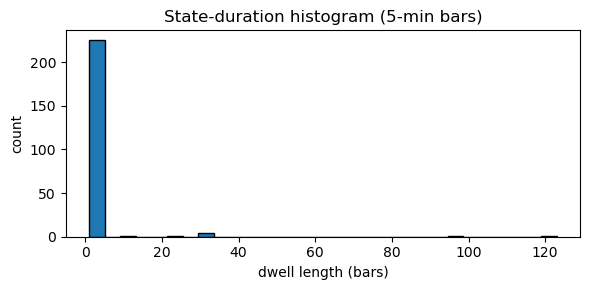

✅  Histogram saved → plots/state_duration.png


In [216]:
# =========================================================
#  4.7  Dwell-time histogram  ➜ plots/state_duration.png
# =========================================================
import matplotlib.pyplot as plt, os
os.makedirs("plots", exist_ok=True)

# compute consecutive run lengths
durations = []
prev, run = None, 0
for s in decoded["state"]:
    if s == prev:
        run += 1
    else:
        if prev is not None:
            durations.append(run)
        run, prev = 1, s
durations.append(run)

plt.figure(figsize=(6,3))
plt.hist(durations, bins=30, edgecolor="k")
plt.title("State-duration histogram (5-min bars)")
plt.xlabel("dwell length (bars)"); plt.ylabel("count")
plt.tight_layout()
plt.savefig("plots/state_duration.png", dpi=120)
plt.show()

print("✅  Histogram saved → plots/state_duration.png")


In [218]:
# =========================================================
#  4.8  Per-fold scaler drift  ➜ features/scaler_drift.csv
# =========================================================
rows = []
for yr, train, _ in yearly_folds(feat):
    sc = StandardScaler().fit(train[["log_rv","ac1_5m"]])
    rows.append([yr, *sc.mean_, *sc.scale_])

scaler_drift = pd.DataFrame(rows, columns=["fold","μ_log_rv","μ_ac1",
                                           "σ_log_rv","σ_ac1"])
scaler_drift.to_csv("features/scaler_drift.csv", index=False)
print("✅  Scaler drift table → features/scaler_drift.csv")
display(scaler_drift)


✅  Scaler drift table → features/scaler_drift.csv


,fold,μ_log_rv,μ_ac1,σ_log_rv,σ_ac1
0,2026,-8.711003,-0.0405,0.607436,0.1745


In [220]:
import shutil, os, glob

os.makedirs("bundle", exist_ok=True)
for f in glob.glob("models/*.pkl"):           shutil.copy(f, "bundle")
for f in ["features/hmm_states.parquet",
          "features/hmm_robustness.csv",
          "features/hmm_likelihood_compare.csv",
          "features/scaler_drift.csv",
          "plots/state_duration.png"]:
    shutil.copy(f, "bundle")

shutil.make_archive("regime_model_bundle_v1", "zip", "bundle")
print("✅  zipped → regime_model_bundle_v1.zip")


✅  zipped → regime_model_bundle_v1.zip
